<a href="http://landlab.github.io"><img style="float: left" src="https://raw.githubusercontent.com/landlab/tutorials/master/landlab_header.png"></a>



# Introduction to the Landlab SpeciesEvolver component

<hr>
<small> For instructions on how to run an interactive iPython notebook, click here: <a href="https://github.com/landlab/tutorials/blob/master/README.md">https://github.com/landlab/tutorials/blob/master/README.md</a></small><br>
<small>For more Landlab tutorials, click here: <a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a></small>
<hr>

*After completing this tutorial, you will know how to use* SpeciesEvolver *with the default parameters and implementation.*

## Tutorial example: simulate the response of zone-based species to climate change

We will simulate species response to climate change using `ZoneSpecies`. This species type relies on `Zone` objects to evaluate evolutionary processes. The general workflow we will conduct is

* Define a function that demarcates the combined extent of all zones. 
* Populate each distinct zone with a species.
* Simulate a time step where surface temperature has changed and species respond to this change.

### Import modules

Individual and groups of species are managed by a `SpeciesController`.

ZoneSpecies are managed by `ZoneSpeciesController`, so we must import this class along with the SpeciesEvolver component and the other modules used in this notebook

In [1]:
from landlab.components import SpeciesEvolver
from landlab.components.species_evolution import ZoneSpeciesController
from landlab.io import read_esri_ascii
from landlab.plot import imshow_grid
import matplotlib.pyplot as plt
import numpy as np

/Users/njlyons/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


### Prepare the grid

Load and plot the initial topography. The top and bottom boundaries are set to open. The initial topography was previously created using a model built with Landlab. The model was run until topography reached steady state.

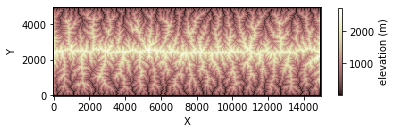

In [2]:
(mg, z) = read_esri_ascii('model_grid_steady_state_elevation.txt')
mg.at_node['topographic__elevation'] = z
mg.set_closed_boundaries_at_grid_edges(right_is_closed=True,
                                       top_is_closed=False,
                                       left_is_closed=True,
                                       bottom_is_closed=False)

imshow_grid(mg, 'topographic__elevation', colorbar_label='elevation (m)', shrink=0.4)

#### Create and plot a grid field of the air temperature at the land surface

We use a lapse rate of 5&deg;C / km.

9.59590309985 25.9999927129


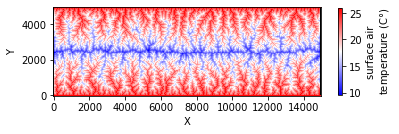

In [3]:
lapse = -0.006

# Set surface temperature at sea level.
temperature_at_sea_level = 26
mg.at_node['land_surface_air__temperature'] = lapse * mg.at_node['topographic__elevation'] + temperature_at_sea_level
print(mg.at_node['land_surface_air__temperature'].min(), mg.at_node['land_surface_air__temperature'].max())

# Plot temperature field.
imshow_grid(mg, 'land_surface_air__temperature',
            colorbar_label='surface air\ntemperature (C$\degree$)',
            shrink=0.4, cmap='bwr')

### Initialize SpeciesEvolver

This component requires only one parameter, a model grid, for the default functionality.

In [4]:
se = SpeciesEvolver(mg)

View the `record` of the component instance. Time and other model variables are stored in the record. The first and second columns are the row number and model time, respectively.

In [5]:
se.record

,time
0,0


### Create a zone function

Zones are portions of a model grid. A `ZoneSpecies` object exists within a zone. `Zone` objects are explained in more detail later in this tutorial.

The zone function must return a numpy array with the length of the grid's `number_of_nodes`. True values indicate where zones should be created. 

Here, we indicate zones should be created where the air temperature is between 15&deg;C and 25&deg;C, inclusive. The temperature of all nodes is within this interval, therefore all elements of the mask are `True`.

In [6]:
def zone_func(grid, **kwargs):
    """Get a mask of the total zone extent."""
    T = grid.at_node['land_surface_air__temperature']
    T_max = 25
    T_min = 15
    zone_extent_mask = np.all([T >= T_min, T <= T_max], 0)
    return zone_extent_mask

`True` values are shaded white in the plot below

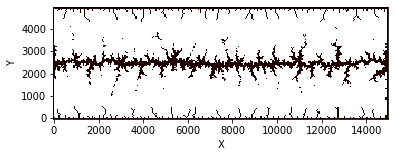

In [7]:
imshow_grid(mg, zone_func(mg), allow_colorbar=False)

## Create a species that exists in the zone

The initial zone is populated by instantiating a species with the zone as its parameter. The species must then be introduced to SpeciesEvolver in order for the species to be tracked and to evolve over time.

The type of species that will be simulated is evolved by these processes:
* dispersal: geographic range expansion
* speciation: lineage splitting
* extinction: lineage termination

Also below, we print all the species that exist in SpeciesEvolver. Only the one species exists; the species we introduced. Further below, the `clade` and `species_number` identifier elements will be explained.

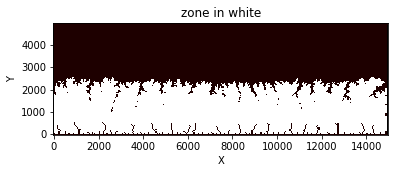

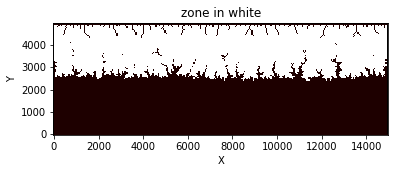

In [8]:
sc = ZoneSpeciesController(se, zone_func, minimum_area=50000, grid=mg)

# Plot zones.
for zone in sc.zones:
    plt.figure()
    imshow_grid(mg, zone.mask, allow_colorbar=False, plot_name='zone in white')

In [9]:
sc.populate_each_zone(1)

# Print the species data frame.
se.species

,clade,species_number,time_appeared,latest_time
0,A,0,0,0
1,B,0,0,0


### Simulate the effect of changing zone definition on species

< about climate elevation gradient >

For example, ecosystems are zonated by elevation.

If temperature decreased by 4&deg;C at sea level (the elevation at the upper and lower grid bounderies), then the 800 m zone maximum would lower by about 409 m assuming a lapse rate of 9.8&deg;C / 1000 m.

Next, we set the zones of species are limited to areas with an elevation less than 400. Two distinct areas of the mask are now seperated by the higher elevations in the center of the grid.

15.5959030999 31.9999927129


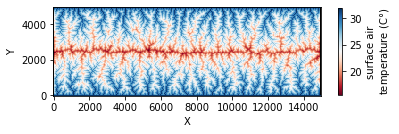

In [10]:
# Update surface temperature at sea level.
temperature_at_sea_level = 32
mg.at_node['land_surface_air__temperature'] = lapse * mg.at_node['topographic__elevation'] + temperature_at_sea_level
print(mg.at_node['land_surface_air__temperature'].min(), mg.at_node['land_surface_air__temperature'].max())
# Plot temperature field.
imshow_grid(mg, 'land_surface_air__temperature',
            colorbar_label='surface air\ntemperature (C$\degree$)',
            shrink=0.4, cmap='RdBu')

bbb 2


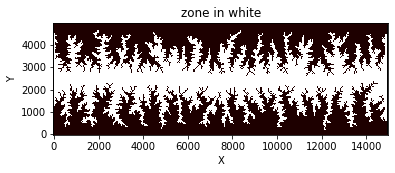

In [11]:
# Advance SpeciesEvolver by one unit of time. Time is dimensionless in this tutorial.
dt = 1
se.run_one_step(dt)

# Plot zones.
for zone in sc.zones:
    plt.figure()
    imshow_grid(mg, zone.mask, allow_colorbar=False, plot_name='zone in white')

In [12]:
sc.zones

21.5959030999 37.9999927129


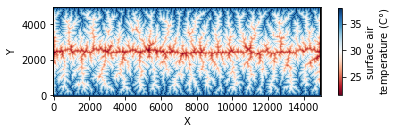

In [13]:
# Update surface temperature at sea level.
temperature_at_sea_level = 38
mg.at_node['land_surface_air__temperature'] = lapse * mg.at_node['topographic__elevation'] + temperature_at_sea_level
print(mg.at_node['land_surface_air__temperature'].min(), mg.at_node['land_surface_air__temperature'].max())
# Plot temperature field.
imshow_grid(mg, 'land_surface_air__temperature',
            colorbar_label='surface air\ntemperature (C$\degree$)',
            shrink=0.4, cmap='RdBu')

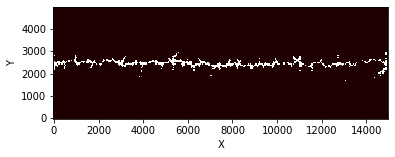

In [14]:
imshow_grid(mg, zone_func(mg), allow_colorbar=False)

Increment SpeciesEvolver using the `run_one_step` method. The only parameter of this method is the time step duration. Here we use 1000 to signify 1000 yrs. This method evaluates and updates the zones and species of SpeciesEvolver.

The `run_one_step` method determined that two distinct zones now exist.

bbb 2
bbb 2
bbb 2
bbb 2
bbb 2
bbb 2
bbb 2
bbb 2
bbb 2
bbb 2
bbb 2
bbb 2
bbb 2
bbb 2
bbb 2
bbb 2


,clade,species_number,time_appeared,latest_time
0,A,0,0,1
1,A,1,2,2
2,A,2,2,2
3,A,3,2,2
4,A,4,2,2
5,A,5,2,2
6,A,6,2,2
7,A,7,2,2
8,A,8,2,2
9,A,9,2,2


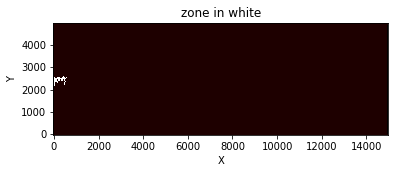

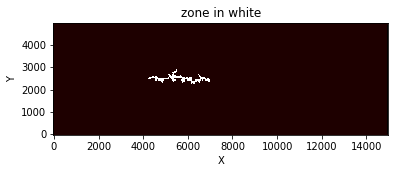

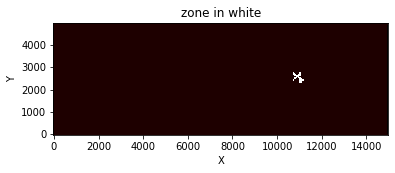

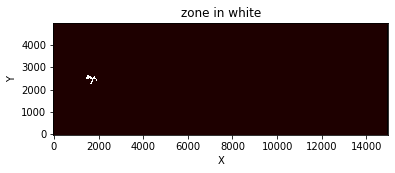

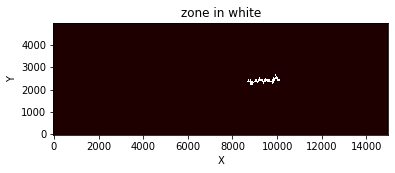

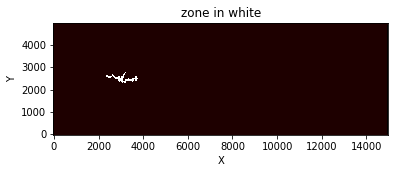

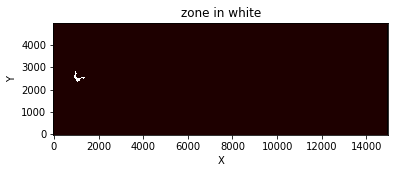

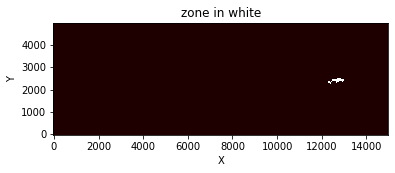

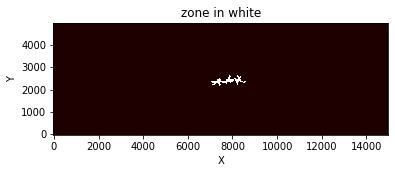

In [15]:
# Advance SpeciesEvolver by one unit of time. Time is dimensionless in this tutorial.
dt = 1
se.run_one_step(dt)

# Plot zones.
for zone in sc.zones:
    plt.figure()
    imshow_grid(mg, zone.mask, allow_colorbar=False, plot_name='zone in white')

se.species

In [16]:
print(se.record)
se.run_one_step(dt)

sc._species

   time
0     0
1     1
2     2


Three species have existed in this model:

- A.0: The initial species we introduced.
- A.1 and A.2: The child species of A.0. These species were created when the zone of the first time step split into two in the second time step.

All species belong to clade 'A' because the child species (A.1 and A.2) were spawned from the same parent species (A.0).

In [17]:
se._delegate._species

OrderedDict([('clade',
              ['A',
               'B',
               'B',
               'B',
               'B',
               'A',
               'B',
               'A',
               'A',
               'B',
               'A',
               'B',
               'B',
               'B',
               'A',
               'B',
               'A',
               'B',
               'A',
               'A',
               'A']),
             ('species_number',
              [0,
               0,
               1,
               8,
               10,
               6,
               5,
               1,
               7,
               7,
               8,
               2,
               4,
               9,
               9,
               6,
               4,
               3,
               3,
               2,
               5]),
             ('time_appeared',
              [0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
             ('latest_time',
  

## Species identifiers

Species identifiers are automatically generated. They are stored as tuples in species objects. The first element of the identifier tuple is the clade name, and the second element is the species number. For example, the first species of clade A is 0, so the identifier is (A, 0) and the tenth species of this clade is (A, 9).

### Clade name

A clade is a group of species that share a common ancestor. Species may share multiple common ancestors, so clades can be defined differently in the same tree. The clade(s) of this example tree can be defined in multiple ways:

<img src="images/clade_definitions.png" style="width: 400px;"/>

In SpeciesEvolver, clades are defined by the root node for the purpose of assigning species identifiers. The species at the root node is:
* the least recent common ancestor of all species in the tree, and
* typically introduced to a SpeciesEvolver model using the ```introduce_species``` function.

The clades of the first 26 species are named alphabetically from A to Z. The alphabet is repeated for subsequent species following this schema:

<center>clade sequence</center> | <center>clade name</center>
--- | ---
1–26 | A–Z
27–52 | AA–AZ
53–78 | BA–BZ
... | ...
703–728 | AAA–AAZ
729–754 | ABA–ABZ
... | ...

### Species number

Species are numbered sequently by clade beginning with 0.

In the example tree below, species A.0 produced 4 child species. Only one species, B.0 exists in clade B because child species were not produced by B.0.

<img src="images/species_identifier.png" style="width: 250px;"/>

In [18]:
temperature_at_sea_level = 20
mg.at_node['land_surface_air__temperature'] = -0.006 * mg.at_node['topographic__elevation'] + temperature_at_sea_level
print(mg.at_node['land_surface_air__temperature'].min(), mg.at_node['land_surface_air__temperature'].max())
se.run_one_step(dt)

3.59590309985 19.9999927129
bbb 0
bbb 0
bbb 0
bbb 0
bbb 0
bbb 0
bbb 0
bbb 0
bbb 0
bbb 0
bbb 0
bbb 0
bbb 0
bbb 0
bbb 0
bbb 0
bbb 0
bbb 0


In [19]:
for zone in sc.zones:
    plt.figure()
    imshow_grid(mg, zone.mask, allow_colorbar=False, plot_name='zone in white')

### About Zones

Zones are portions of a model grid. A Species object exists throughout a zone.

At each timestep, the spatial intersection of the zones at the prior time and current time are identified and typed. For example, a zone in the prior time intersects two zones in the current time. This zone path is typed one-to-many.

Macroevolutionary processes are carried out by the intersection of zones over time. The connectivity of zones in SpeciesEvolver are called 'paths', and the relationship of zones is described by the path type. Not all combinations of none, one, and many are considered at the time of this tutorial. All none-to-n and some many-to-n are not considered. 

<img style="float: left;" src="images/zone__one_to_none.png"> &nbsp; zone<sub>*t*</sub>: a zone in time, *t*.<br>

<img style="float: left;" src="images/zone__later_time.png"> &nbsp; zone<sub>*t*+1</sub>: a zone in the time following *t*.

<center>path type</center> | <center>graphical<br>represention</center> | <center>zone temporal connectivity</center> | <center>macroevolution implications</center>
--- | --- | --- | ---
one-to-none | ![](images/zone__one_to_none.png) | zone<sub>*t*</sub> does not intersect a zone in *t*+1. | The species in the zone of the earlier time will go extinct. 
one-to-one | ![](images/zone__one_to_one.png) | zone<sub>*t*</sub> intersects zone<sub>*t*+1</sub>. | The species in the zone of the earlier time will relocate to the zone of the later time.
one-to-many | ![](images/zone__one_to_many.png) | zone<sub>*t*</sub> intersects multiple zones in *t*+1. | The species in the zone of the earlier time disperses across the multiple zones in the later time. The species in the zones of the later time are geographical disconnected, thus speciation occurs.
many-to-one | ![](images/zone__many_to_one.png) | Multiple zones in *t* intersect zone<sub>*t*+1</sub>. | Species density increases locally.
many-to-many | ![](images/zone__many_to_many.png) | Multiple zones in *t* intersect multiple zones in *t*+1. | Species distribution shifts. Speciation occurs where the zone of a species at *t* intersects more than one zone at *t*+1.

The rules of macroevolution are programmed into species. Behind the scenes, zone paths are the conditions evaluated by the macroevolution rules. The outcome of the rules given the zone paths are described in the zone table above. For example, a one-to-many path:

![](images/zone_path__one_to_many.png)

The base species class 

Users may develop species with different behaviors and macroevolution rules.





Populate SpeciesEvolver zones with species.



In [20]:
se.species

,clade,species_number,time_appeared,latest_time
0,A,0,0,1
1,A,1,2,3
2,A,2,2,3
3,A,3,2,3
4,A,4,2,3
5,A,5,2,3
6,A,6,2,3
7,A,7,2,3
8,A,8,2,3
9,A,9,2,3


In [21]:
temperature_at_sea_level = 20
mg.at_node['land_surface_air__temperature'] = 0.006 * mg.at_node['topographic__elevation'] + temperature_at_sea_level
se.run_one_step(dt)

In [22]:
se.species

,clade,species_number,time_appeared,latest_time
0,A,0,0,1
1,A,1,2,3
2,A,2,2,3
3,A,3,2,3
4,A,4,2,3
5,A,5,2,3
6,A,6,2,3
7,A,7,2,3
8,A,8,2,3
9,A,9,2,3


In [23]:
temperature_at_sea_level = 16
mg.at_node['land_surface_air__temperature'] = 0.006 * mg.at_node['topographic__elevation'] + temperature_at_sea_level
se.run_one_step(dt)
print(mg.at_node['land_surface_air__temperature'].min(), mg.at_node['land_surface_air__temperature'].max())
se.species



16.0000072871 32.4040969001


,clade,species_number,time_appeared,latest_time
0,A,0,0,1
1,A,1,2,3
2,A,2,2,3
3,A,3,2,3
4,A,4,2,3
5,A,5,2,3
6,A,6,2,3
7,A,7,2,3
8,A,8,2,3
9,A,9,2,3


In [24]:
se.record

,time
0,0
1,1
2,2
3,3
4,4
5,5
6,6


### Click here for more <a href="https://github.com/landlab/landlab/wiki/Tutorials">Landlab tutorials</a>